In [1]:
using Plots
using LinearAlgebra
using Jacobi
using Test
using SparseArrays

# Bilinear Map, Prime and Nodal Basis

In [2]:
function BilinearMap(Coord_E, xhat, yhat)
    """ 
    This function maps [xhat,yhat] in Ehat=[-1,1]^2 
    to (x,y) in quadrilateral E.
    Input:
    ------
    coord_E: coordinates of quadrilateral E .
    coord_E is 4x2 array
    coord_E = [x1 y1;x2 y2;x3 y3;x4 y4] with vertices numbering
    3----4
    |    |
    1----2
    [xhat, yhat] in Ehat
    Output:
    ------
    x, y: mapped vector in E.
    DF_E: Jacobian matrix
    J_E: det(DF_E)
    """
    m = length(xhat)
    N1 = @. 0.25*(1-xhat)*(1-yhat)
    N2 = @. 0.25*(1+xhat)*(1-yhat)
    N3 = @. 0.25*(1-xhat)*(1+yhat)
    N4 = @. 0.25*(1+xhat)*(1+yhat)
    N = [N1 N2 N3 N4]
    X = N * Coord_E
    # X(2,m), 1st row x, 2nd row y,
    X = X'
    # gradient of N, [dN/dxhat; dN/dyhat]
    GradN = zeros(2,m,4)
    GradN[1,:,:] = @. 0.25*[-(1-yhat) (1-yhat) -(1+yhat) (1+yhat)]
    GradN[2,:,:] = @. 0.25*[-(1-xhat) -(1+xhat) (1-xhat) (1+xhat)]

    # JT = [[dx/dxhat, dy/dxhat],
    #       [dx/dyhat, dy/dyhat]] (3m x 3)

    JTxhat = GradN[1,:,:] * Coord_E
    dxdxhat = JTxhat[:,1]
    dydxhat = JTxhat[:,2]
    JTyhat = GradN[2,:,:] * Coord_E
    dxdyhat = JTyhat[:,1]
    dydyhat = JTyhat[:,2]

    # compute det
    detJ = @. dxdxhat*dydyhat - dydxhat*dxdyhat
    
    J = zeros(2,m,2)
    J[1,:,:] = [dxdxhat dxdyhat]
    J[2,:,:] = [dydxhat dydyhat]
    
    return X, J, detJ
end

function GetNormal(Coord_E, xhat, yhat)
    """
    Input:
    ------
    coord_E: vertices coordinate of element E
    (xhat,yhat): coordinate of the edge in element Ehat=[-1,1]^2

    Output:
    -------
    n: computed normal of an edge of element E
    """

    X, J, detJ = BilinearMap(Coord_E, xhat, yhat)
    
    dxdxhat = J[1,:,1]
    dydxhat = J[2,:,1]
    
    dxdyhat = J[1,:,2]
    dydyhat = J[2,:,2]
    m = length(xhat)
    
    if (xhat == -ones(m) && -ones(m) < yhat < ones(m))
        # left edge, (0,0,1)x(dxdyhat,dydyhat,0)
        n1 = @. -dydyhat
        n2 = @. dxdyhat
        leng = @. sqrt(n1*n1 + n2*n2)
        n = zeros(2,m)
        n[1,:] = n1 ./ leng
        n[2,:] = n2 ./ leng

    elseif (xhat == ones(m) && -ones(m) < yhat < ones(m))
        # right edge, (0,0,-1)x(dxdyhat,dydyhat,0)
        n1 = @. dydyhat
        n2 = @. -dxdyhat
        leng = @. sqrt(n1*n1 + n2*n2)
        n = zeros(2,m)
        n[1,:] = n1 ./ leng
        n[2,:] = n2 ./ leng

    elseif (yhat == -ones(m) && -ones(m) < xhat < ones(m))
        # bottom edge, (0,0,-1)x(dxdxhat,dydxhat,0)
        n1 = @. dydxhat
        n2 = @. -dxdxhat
        leng = @. sqrt(n1*n1 + n2*n2)
        n = zeros(2,m)
        n[1,:] = n1 ./ leng
        n[2,:] = n2 ./ leng

    elseif (yhat == ones(m) && -ones(m) < xhat < ones(m))
        # top edge, (0,0,1)x(dxdxhat,dydxhat,0)
        n1 = @. -dydxhat
        n2 = @. dxdxhat
        leng = @. sqrt(n1*n1 + n2*n2)
        n = zeros(2,m)
        n[1,:] = n1 ./ leng
        n[2,:] = n2 ./ leng
    else
        error("edge is not defined")
    end

    return n, leng
end

GetNormal (generic function with 1 method)

In [3]:
function GetBasis(xhat, yhat)
    """
    This basis is created and tested in t330-basis.
    We create basis as a matrix of size (2*num_qpts,8)
    The first 1:num_qpts is dof in x-direction
    and num_qpts+1:2*num_qpts is dof in y-direction
    """

    m = length(xhat)
    Nhat = zeros(2m,8)
    Nhat[1:m,1] = @. -0.25 + 0.25*xhat + 0.25*yhat + -0.25*xhat*yhat
    Nhat[m+1:2*m,1] = @. -0.125 + 0.125*yhat*yhat

    Nhat[1:m,2] = @. 0.25 + 0.25*xhat + -0.25*yhat + -0.25*xhat*yhat
    Nhat[m+1:2*m,2] = @. -0.125 + 0.125*yhat*yhat

    Nhat[1:m,3] = @. -0.25 + 0.25*xhat + -0.25*yhat + 0.25*xhat*yhat
    Nhat[m+1:2*m,3] = @. 0.125 + -0.125*yhat*yhat

    Nhat[1:m,4] = @. 0.25 + 0.25*xhat + 0.25*yhat + 0.25*xhat*yhat
    Nhat[m+1:2*m,4] = @. 0.125 + -0.125*yhat*yhat
    
    Nhat[1:m,5] = @. -0.125 + 0.125*xhat*xhat
    Nhat[m+1:2*m,5] = @. -0.25 + 0.25*xhat + 0.25*yhat + -0.25*xhat*yhat
    
    Nhat[1:m,6] = @. 0.125 + -0.125*xhat*xhat
    Nhat[m+1:2*m,6] = @. -0.25 + -0.25*xhat + 0.25*yhat + 0.25*xhat*yhat
    
    Nhat[1:m,7] = @. -0.125 + 0.125*xhat*xhat
    Nhat[m+1:2*m,7] = @. 0.25 + -0.25*xhat + 0.25*yhat + -0.25*xhat*yhat
    
    Nhat[1:m,8] = @. 0.125 + -0.125*xhat*xhat
    Nhat[m+1:2*m,8] = @. 0.25 + 0.25*xhat + 0.25*yhat + 0.25*xhat*yhat
    
    return Nhat
end

GetBasis (generic function with 1 method)

In [4]:
function GetQuadrature2D(Q, quad_mode)
    """ 
    Input:
    Q: number of quadrature points in 1D over [-1,1]
    quad_mode: GAUSS or LOBATTO
    Return:Gauss Quadrature over [-1,1]^2.
    qx:
    qy:
    w2:
    """
    
    # 1D Gauss
    if quad_mode == "GAUSS"
        q = zgj(Q, 0.0, 0.0)
        w = wgj(q, 0.0, 0.0)
    elseif quad_mode == "LOBATTO"
        q = zglj(Q, 0.0, 0.0)
        w = wglj(q, 0.0, 0.0)
    end
    w2 = zeros(Q*Q)
    qx = zeros(Q*Q)
    qy = zeros(Q*Q)
    for i=1:Q
        for j=1:Q
            k = (i-1)*Q +j
            qx[k] = q[j]
            qy[k] = q[i]
            w2[k] = w[j]*w[i]
        end
    end
    return w2, qx, qy
end

GetQuadrature2D (generic function with 1 method)

# Create rhs qfunction and check with libCEED
$$\int v^T J^T u_e w $$

In [5]:
function VelocityLinear(x, y)
    m = length(x)
    ux = @. (1*(x+y))
    uy = @. (1*(x-y))
    
    ue = zeros(2,m)
    ue[1,:] = ux
    ue[2,:] = uy
    return ue
end

function VelocityConstant(x, y)
    m = length(x)
    ux =  3
    uy =  4
    
    ue = zeros(2,m)
    ue[1,:] .= ux
    ue[2,:] .= uy
    return ue
end

VelocityConstant (generic function with 1 method)

In [6]:
function DiscretizeUe(Coord_E, uexact)
    """
    This function discretize the vector u = uexact(x,
    y,z) on element E
    """
    # get the normals
    nl, le_l = GetNormal(Coord_E, [-1.], [0.])
    nr, le_r = GetNormal(Coord_E, [1.], [0.])
    nb, le_b = GetNormal(Coord_E, [0.], [-1.])
    nt, le_t = GetNormal(Coord_E, [0.], [1.])
    
    nb = nb*le_b
    nt = nt*le_t
    nr = nr*le_r
    nl = nl*le_l

    node1 = Coord_E[1,:]
    node2 = Coord_E[2,:]
    node3 = Coord_E[3,:]
    node4 = Coord_E[4,:]
    
    normals = [nl nr nl nr nb nb nt nt]
    nodes = [node1 node2 node3 node4 node1 node2 node3 node4]
    
    x = nodes[1,:]
    y = nodes[2,:]
    uu = uexact(x,y)
    ue = uu[1,:] .* normals[1,:] + uu[2,:] .* normals[2,:]
    
    return ue
end


DiscretizeUe (generic function with 1 method)

In [7]:
function GetRhs(Coord_E, Q, quad_mode, uexact)
    
    w, qx, qy = GetQuadrature2D(Q, quad_mode)
    # total number of quadrature points
    num_qpts = Q*Q
    # get (x,y,z) on E, detJ,...
    coords, dxdX, detJ = BilinearMap(Coord_E, qx, qy)
    x = coords[1,:]
    y = coords[2,:]
    
    ue = uexact(x,y)
    # output of qfunction
    rhs2 = zeros(2*num_qpts,1)
    for i=1:num_qpts
        J = dxdX[:,i,:]
        uu = ue[:,i]
        rhs1 = J' * uu       
        # component 1
        rhs2[i+0*num_qpts, 1] = rhs1[1] *w[i]
        # component 2
        rhs2[i+1*num_qpts, 1] = rhs1[2] *w[i]
    end 
    
    v = GetBasis(qx, qy);
    # ApplyBasis
    rhs = v' * rhs2
    
    return rhs
end

GetRhs (generic function with 1 method)

In [8]:
Q = 5
C_E = [0 0;1 0;0 1;1 1]
mode = "GAUSS"
uexact(x,y) = VelocityLinear(x,y)
#uexact(x,y) = VelocityConstant(x,y)
ue = DiscretizeUe(C_E, uexact);
rhs = GetRhs(C_E, Q, mode, uexact)

8×1 Matrix{Float64}:
 -0.33333333333333326
  0.5
 -0.5
  0.6666666666666667
 -0.16666666666666669
 -1.5829351718288365e-17
 -0.33333333333333337
  0.16666666666666663

# Create Local Mass Matrix
$$(v,u_h) = \int \frac{N^T J^T J N w}{detJ} $$

In [9]:
function GetLocalMass(Coord_E, Q, quad_mode)
    
    w, qx, qy = GetQuadrature2D(Q, quad_mode)
    # total number of quadrature points
    num_qpts = Q*Q
    # get (x,y,z) on E, detJ,...
    coords, dxdX, detJ = BilinearMap(Coord_E, qx, qy)
    
    N = GetBasis(qx, qy);
    # output of qfunction
    tmp = zeros(2*num_qpts,8)
    uu = zeros(2,8)
    for i=1:num_qpts
        J = dxdX[:,i,:]
        uu[1,:] = N[i+0*num_qpts,:]
        uu[2,:] = N[i+1*num_qpts,:]
        #J^T * J * N * w / detJ
        tmp2 = J' * J * uu * w[i] /detJ[i]
        # component 1
        tmp[i+0*num_qpts, :] = tmp2[1,:]
        # component 2
        tmp[i+1*num_qpts, :] = tmp2[2,:]
    end 
    
    # ApplyBasis
    Me = N' * tmp
    
    return Me
end

GetLocalMass (generic function with 1 method)

In [10]:
Me = GetLocalMass(C_E, Q, mode)

8×8 Matrix{Float64}:
  0.477778     -0.188889      0.188889     …   1.19398e-17  -0.166667
 -0.188889      0.477778     -0.144444        -0.166667     -2.36356e-17
  0.188889     -0.144444      0.477778         0.166667      9.75782e-18
 -0.144444      0.188889     -0.188889         1.93801e-18   0.166667
  0.166667     -1.3827e-17    2.77048e-17     -0.188889     -0.144444
 -2.01187e-17   0.166667     -0.166667     …  -0.144444     -0.188889
  1.24819e-17  -0.166667      0.166667         0.477778      0.188889
 -0.166667     -8.67362e-18  -5.20417e-18      0.188889      0.477778

# Test Mass matrix

In [11]:
ue = DiscretizeUe(C_E, uexact)
uh = Me \ rhs
@test isapprox(ue, uh;atol=1e-14)

Test Passed

In [12]:
ue

8-element Vector{Float64}:
  0.0
  0.5
 -0.5
  1.0
  0.0
 -0.5
 -0.5
  0.0

This solution is what we expected

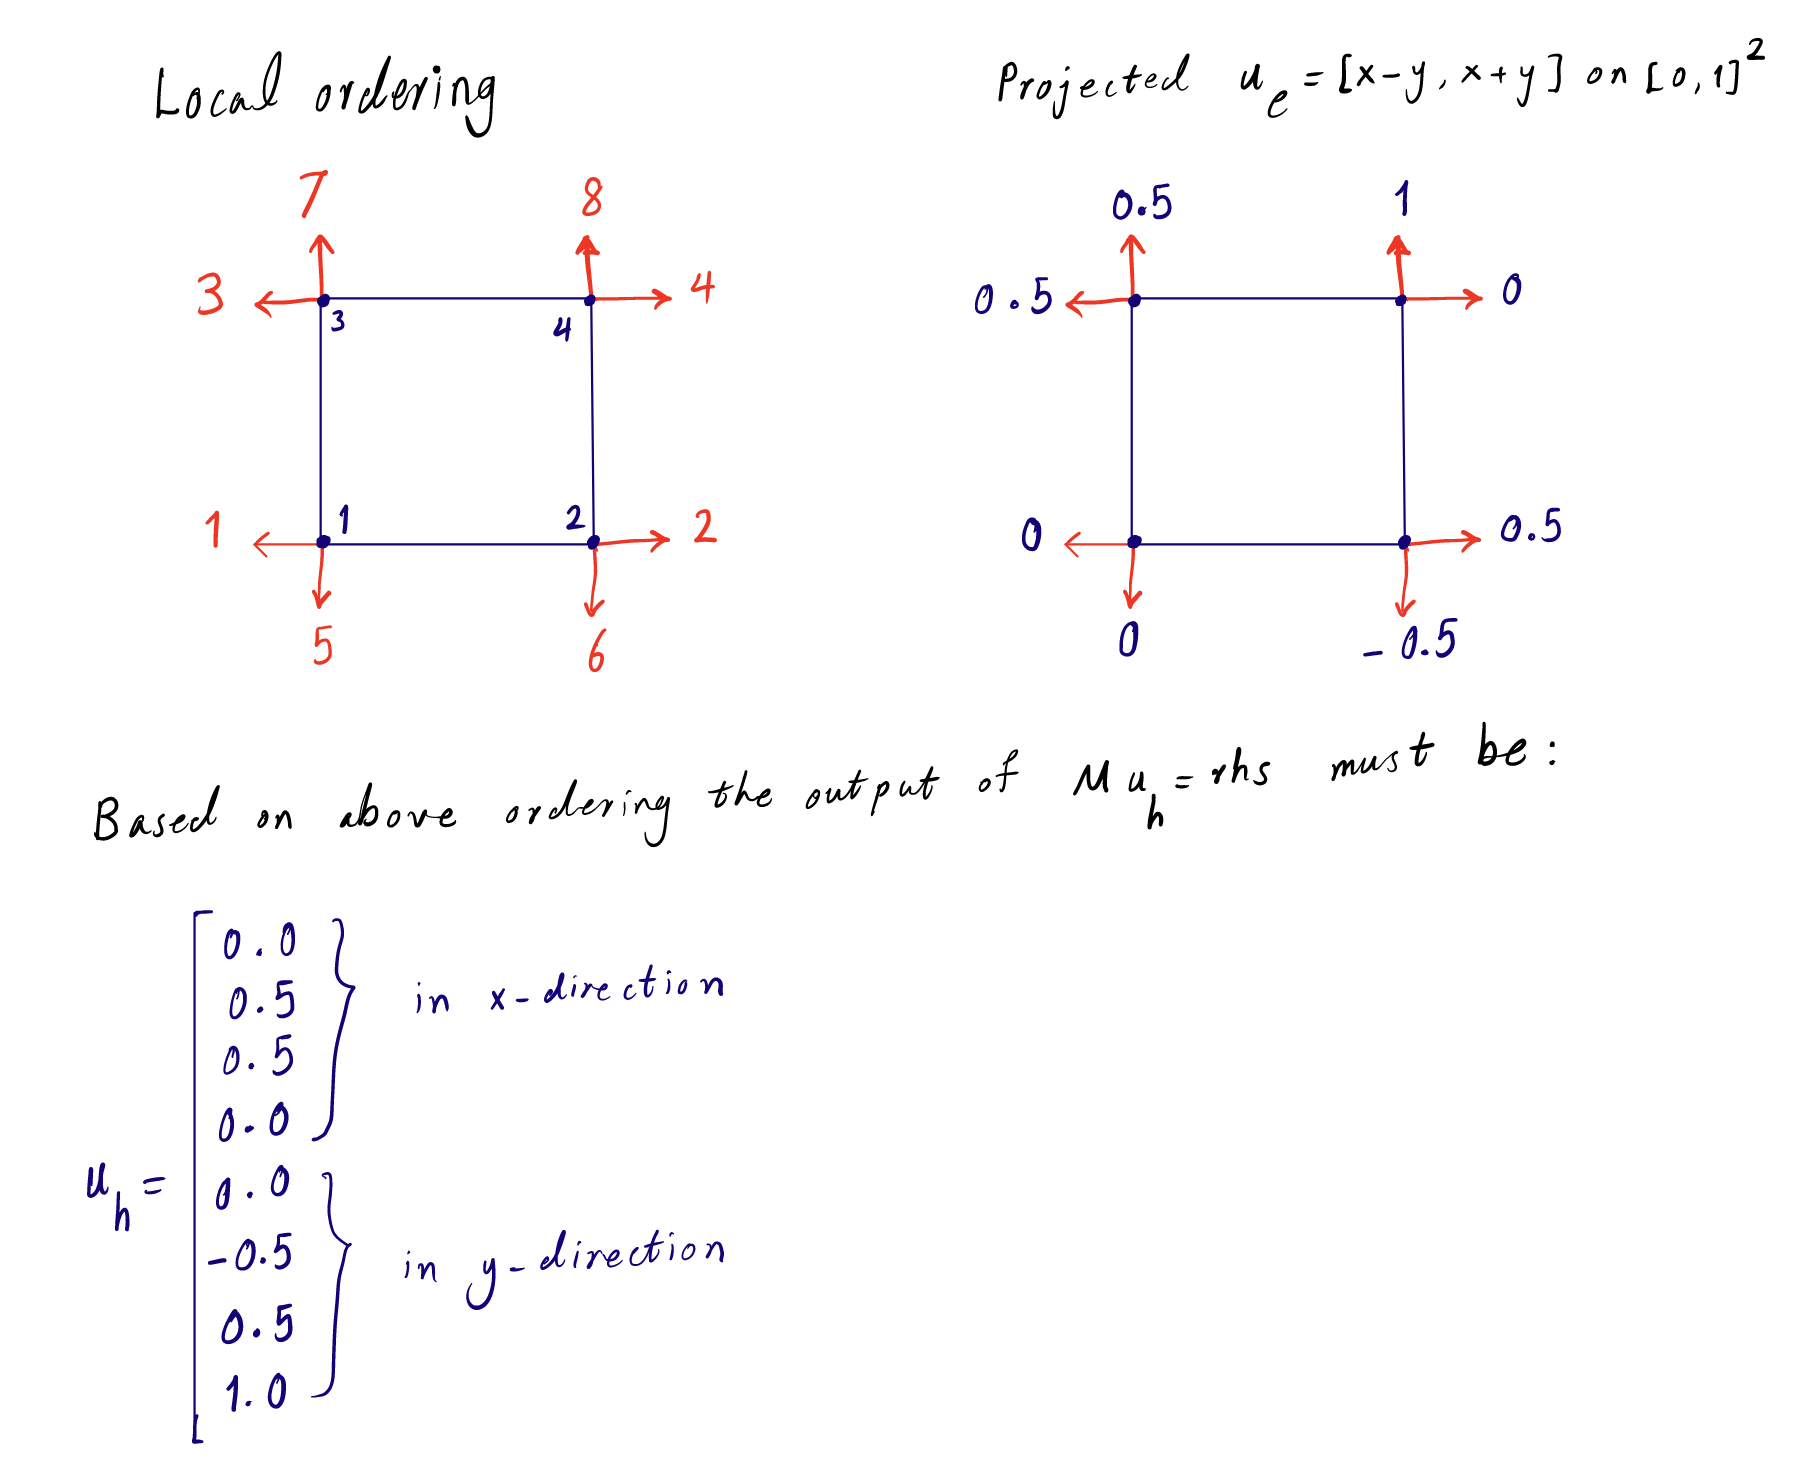